## Data Exploration

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import sys
import os
import pickle
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
sys.path.append("../regression/")
import finance_regression
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [2]:
#Create dataframe from dictionary to quickly explore our data, check types/values, visualize
data_df = pd.DataFrame(data_dict)
data_df = data_df.transpose()

#Force types
numeric_features = [col for col in data_df.columns if col not in ['poi', 'email_address']]
for col in numeric_features:
    data_df[col] = data_df[col].apply(lambda c: pd.to_numeric(c, errors='coerce'))

In [3]:
data_df.sample(5)

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
LEMAISTRE CHARLES,NaN,NaN,-25000.0,112492.0,NaN,412878.0,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,87492.0,412878.0
LEFF DANIEL P,1000000.0,NaN,NaN,NaN,dan.leff@enron.com,NaN,NaN,63.0,67.0,14.0,...,1387399.0,3083.0,False,360528.0,NaN,273746.0,2672.0,2822.0,2664228.0,360528.0
BAZELIDES PHILIP J,NaN,684694.0,NaN,NaN,NaN,1599641.0,NaN,NaN,NaN,NaN,...,93750.0,874.0,False,NaN,NaN,80818.0,NaN,NaN,860136.0,1599641.0
CARTER REBECCA C,300000.0,NaN,-159792.0,NaN,rebecca.carter@enron.com,NaN,NaN,15.0,29.0,7.0,...,75000.0,540.0,False,307301.0,-307301.0,261809.0,196.0,312.0,477557.0,NaN
GOLD JOSEPH,750000.0,NaN,NaN,NaN,joe.gold@enron.com,436515.0,NaN,NaN,NaN,NaN,...,304805.0,819288.0,False,441096.0,NaN,272880.0,NaN,NaN,2146973.0,877611.0


In [4]:
data_df.info(verbose='True')

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                146 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null object
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with_poi      86 non-null float

We see that we have 146 entries in our dataframe, meaning that we have 146 training points.  
One column gives me one feature. There are 21 features. *POI* and *email_address* are of type string. All the other features are numerical.  
Some of our features possess some NaN values: *loan_advances*, *restricted_stock_deferred* have only 4 and 18 non NaN values respectively. So I can already exclude them from my features selection.

In [5]:
type(data_df[data_df['poi']==True].info(verbose='True'))

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, BELDEN TIMOTHY N to YEAGER F SCOTT
Data columns (total 21 columns):
bonus                        16 non-null float64
deferral_payments            5 non-null float64
deferred_income              11 non-null float64
director_fees                0 non-null float64
email_address                18 non-null object
exercised_stock_options      12 non-null float64
expenses                     18 non-null float64
from_messages                14 non-null float64
from_poi_to_this_person      14 non-null float64
from_this_person_to_poi      14 non-null float64
loan_advances                1 non-null float64
long_term_incentive          12 non-null float64
other                        18 non-null float64
poi                          18 non-null object
restricted_stock             17 non-null float64
restricted_stock_deferred    0 non-null float64
salary                       17 non-null float64
shared_receipt_with_poi      14 non-null float64

NoneType

In the dataset, there are 18 POIs. We don't always have features for POI without NaN values.

## Regression
To get a first visualization of our data, let me reuse the finance_regression.py which is part of the udacity teaching materials.

slope:  [ 5.44814029]
intercept:  -102360.543294
score on training data:  0.0455091926995
score on test data:  -1.48499241737
slope new regression line:  [ 2.27410114]


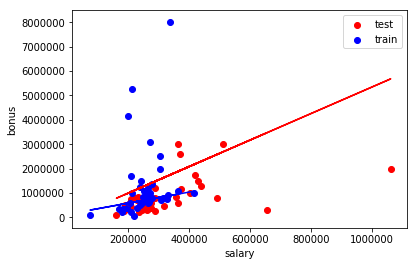

In [6]:
finance_regression.regr()

## Features selection
My hunch is that the following features shall be among the ones containing the most " information" and that they should make a good classifier:
- financial features:
    - bonus
    - exercised_stock_options
    - salary
- mail features:
    - from_poi_to_this_person
    - from_this_person_to_poi
    - shared_receipt_with_poi
    
To confirm it and also to be sure to select the most useful features, let me try using *sklearn.feature_selection.selectKbest*.
And from now on I will use the imported featureFormat and targetFeatureSplit function to get my features instead of working the previously defined dataframe.

In [31]:
features_list=[col for col in data_df.columns if col not in ['email_address','poi']]
features_list=['poi']+features_list
data_dict.pop('TOTAL',0) # remove outlier "TOTAL" already identified in udacity lesson on outliers 
my_dataset = data_dict
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Univariate Selection

In [34]:
features_new = SelectKBest(f_classif, k=6).fit_transform(features,labels) # select 6 best features

#split between train and test set
X_train, X_test, y_train, y_test = train_test_split(features_new, labels, test_size=0.2, random_state=42)

### Try classifiers

In [35]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.93103448275862066

In [95]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'splitter':['best','random'],'min_samples_split':[10,5,4,3,2]}
tree_clf=GridSearchCV(tree,parameters)
tree_clf.fit(X_train, y_train)
print tree_clf.score(X_test, y_test)
print tree_clf.best_estimator_
tree_clf.grid_scores_

0.724137931034
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


[mean: 0.78261, std: 0.02983, params: {'min_samples_split': 10, 'splitter': 'best', 'criterion': 'gini'},
 mean: 0.86087, std: 0.03073, params: {'min_samples_split': 10, 'splitter': 'random', 'criterion': 'gini'},
 mean: 0.80000, std: 0.03071, params: {'min_samples_split': 5, 'splitter': 'best', 'criterion': 'gini'},
 mean: 0.76522, std: 0.05589, params: {'min_samples_split': 5, 'splitter': 'random', 'criterion': 'gini'},
 mean: 0.80870, std: 0.06065, params: {'min_samples_split': 4, 'splitter': 'best', 'criterion': 'gini'},
 mean: 0.82609, std: 0.01146, params: {'min_samples_split': 4, 'splitter': 'random', 'criterion': 'gini'},
 mean: 0.80870, std: 0.03013, params: {'min_samples_split': 3, 'splitter': 'best', 'criterion': 'gini'},
 mean: 0.80870, std: 0.03331, params: {'min_samples_split': 3, 'splitter': 'random', 'criterion': 'gini'},
 mean: 0.77391, std: 0.05382, params: {'min_samples_split': 2, 'splitter': 'best', 'criterion': 'gini'},
 mean: 0.80000, std: 0.01135, params: {'min_s

In [87]:
from sklearn.neighbors import KNeighborsClassifier
KNN=KNeighborsClassifier()
parameters2={'n_neighbors':[20,10,5,4,3],'weights':['uniform','distance']}
KNN_clf=GridSearchCV(KNN, parameters2)
KNN_clf.fit(X_train, y_train)
print KNN_clf.score(X_test, y_test)
print KNN_clf.best_estimator_
KNN_clf.grid_scores_

0.862068965517
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


[mean: 0.86087, std: 0.01050, params: {'n_neighbors': 20, 'weights': 'uniform'},
 mean: 0.86087, std: 0.01050, params: {'n_neighbors': 20, 'weights': 'distance'},
 mean: 0.86087, std: 0.01050, params: {'n_neighbors': 10, 'weights': 'uniform'},
 mean: 0.86087, std: 0.01050, params: {'n_neighbors': 10, 'weights': 'distance'},
 mean: 0.86087, std: 0.01050, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.85217, std: 0.02258, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.86087, std: 0.01050, params: {'n_neighbors': 4, 'weights': 'uniform'},
 mean: 0.86087, std: 0.02391, params: {'n_neighbors': 4, 'weights': 'distance'},
 mean: 0.86957, std: 0.02260, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.86087, std: 0.01327, params: {'n_neighbors': 3, 'weights': 'distance'}]

In [100]:
from sklearn.ensemble import RandomForestClassifier
parameters3={'n_estimators':[3,4,5,10,20,30],'criterion':['gini','entropy'],'min_samples_split':[3,4,5,10,20]}
rdm_forest=RandomForestClassifier()
rdm_forest_clf=GridSearchCV(rdm_forest, parameters3)
rdm_forest_clf.fit(X_train,y_train)
print rdm_forest_clf.score(X_test,y_test)
print rdm_forest_clf.best_estimator_

0.931034482759
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [107]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

for c in [clf, KNN_clf,clf, rdm_forest_clf, tree_clf]:
    print precision_score(y_test,c.predict(X_test)), recall_score(y_test,c.predict(X_test))
    print confusion_matrix(y_test, c.predict(X_test))
    print

0.5 0.5
[[26  1]
 [ 1  1]]

0.25 0.5
[[24  3]
 [ 1  1]]

0.5 0.5
[[26  1]
 [ 1  1]]

0.5 0.5
[[26  1]
 [ 1  1]]

0.125 0.5
[[20  7]
 [ 1  1]]



let's retain naive bayes and random forest
Let'svalidate by using K_fold

In [ ]:
froö sklearn.cross_validation import KFold
rdm_forest_clf=rdm_forest_clf.best_estimator_
